In [2]:
import os
import sys
sys.path.append("..")
import time
import numpy as np
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
from LowLevelModules.Spectroscopy import Spectrum
from LowLevelModules.GeneralFunctions import LivePlot2D, prettify_2d_plot
from LowLevelModules.LightField import LightField

# Initialize LightField --> make sure LF is closed before starting this initialization
LFauto = LightField()

Lightfield startup and setup OK


Keithley stuff

In [3]:
from pymeasure.instruments.keithley import Keithley2400
keithley = Keithley2400("GPIB0::24::INSTR")   # 'ASRL9::INSTR' if RS232 connection
keithley.apply_voltage()                      # Sets up to source voltage
keithley.source_voltage_range = 20             # Sets the source voltage range to 1 V
keithley.compliance_current = 1e-6            # Sets the compliance current to 1 mA
keithley.source_voltage = 0                   # Sets the source current to 0 mA
keithley.measure_current()                    # Sets up to measure voltage

In [4]:
import ipywidgets as widgets
from IPython.display import display

etaloning_choice = widgets.Checkbox(value=False, description='Remove CCD etaloning')
x_axis_choice = widgets.RadioButtons(options=['Wavelength (nm)', 'Energy (eV)'],
                                     value='Wavelength (nm)',
                                     description='X axis unit:')
base_dir_widg = widgets.Text(value=r'Z:\Projects\WSe2\2019',
                            description='Directory: ',
                            disabled=False)
base_name_widg = widgets.Text(value='WSe2',
                              description='Filename: ',
                              disabled=False)
acq_time_widg = widgets.IntSlider(value=10,
                                  min=0,
                                  max=60,
                                  step=1,
                                  description='Acq. time:',
                                  disabled=False,
                                  continuous_update=False,
                                  orientation='horizontal',
                                  readout=True,
                                  readout_format='d'
                            )
v_range_widg = widgets.IntRangeSlider(value=[-5, 5],
                                      min=-20,
                                      max=20,
                                      step=1,
                                      description='V range:',
                                      disabled=False,
                                      continuous_update=False,
                                      orientation='horizontal',
                                      readout=True,
                                      readout_format='d')

display(etaloning_choice)
display(x_axis_choice)
display(base_dir_widg)
display(base_name_widg)
display(acq_time_widg)
display(v_range_widg)

Checkbox(value=False, description='Remove CCD etaloning')

RadioButtons(description='X axis unit:', options=('Wavelength (nm)', 'Energy (eV)'), value='Wavelength (nm)')

Text(value='Z:\\Projects\\WSe2\\2019', description='Directory: ')

Text(value='WSe2', description='Filename: ')

IntSlider(value=10, continuous_update=False, description='Acq. time:', max=60)

IntRangeSlider(value=(-5, 5), continuous_update=False, description='V range:', max=20, min=-20)

<IPython.core.display.Javascript object>


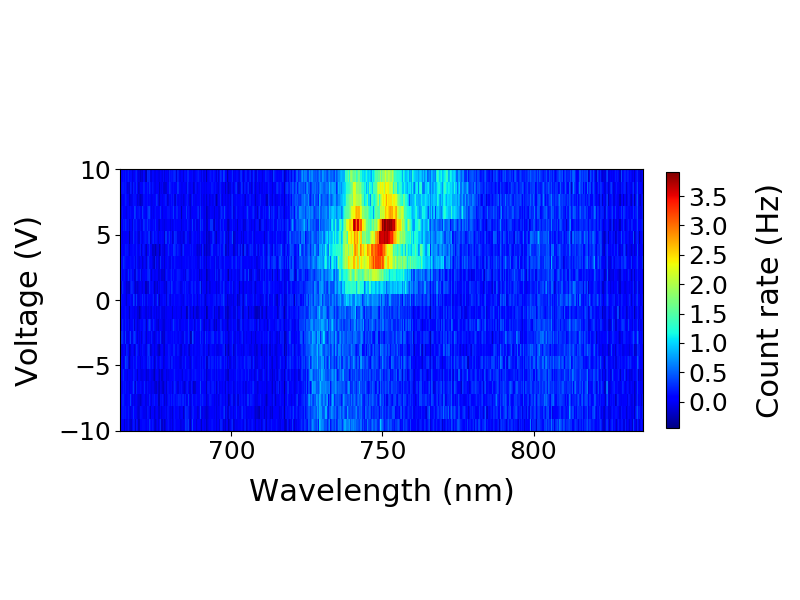

Z:\Projects\WSe2\2019\10 october\2019-10-08 WSe2 on gatedNP\5K data\Vscan\WSe2_gatedNP_5K_40nW_QD2_Vscan.png


In [22]:
import os
wdir = base_dir_widg.value
base_name = base_name_widg.value
scan_step_size = (v_range_widg.value[1] - v_range_widg.value[0]) / 20
V_range = np.arange(v_range_widg.value[0], v_range_widg.value[1] + scan_step_size, scan_step_size)
acq_time = acq_time_widg.value
save_data = True

# Enable the voltage source output
keithley.enable_source()
#deal with LightField settings
LFauto.set_acquisition_time(acq_time)
LFauto.set_path(wdir)
LFauto.set_filename("ref_spect_noV")
LFauto.set_filename_increment()

# Acquire image in LightField
keithley.ramp_to_voltage(0)
if not "ref_spect_noV.spe" in os.listdir(wdir):
    LFauto.acquire()
    
data_ref = LFauto.load_acquired_data(wdir, "ref_spect_noV")
xdata = data_ref.x
ydata = V_range
zdata = np.zeros((len(ydata), len(xdata)))

lp = LivePlot2D(xdata, ydata, zdata, 8, 6)
prettify_2d_plot(lp.ax, lp.cb, x_axis_choice.value, 'Voltage (V)', 'Count rate (Hz)')

for i, v in enumerate(V_range):
    try: 
        # change the voltage
        keithley.ramp_to_voltage(v)
        curr_curr = keithley.current
        # update file name to save data
        LFauto.set_filename(base_name + str(v) + "V")
        # Acquire image
        LFauto.acquire()
        data = LFauto.load_acquired_data(wdir, base_name + str(v) + "V")
        data.remove_cosmic_ray(4)
        if etaloning_choice.value:
            data.remove_etaloning(0.28, 0.46, 0.02, plotplot=False)
    #     if x_axis_choice.value == 'Energy (eV)':
    #         data.x = 1241/data.x
    #         data.x = data.x[::-1]
    #         data.y = data.y[::-1]
    #     if normalize_choice.value:
    #         data.y = data.y / np.max(data.y) + i*0.5

        zdata[i,:] = data.y
        lp.plot_live(zdata)  
    except KeyboardInterrupt:
        break
        
keithley.ramp_to_voltage(0)
keithley.disable_source()

plt.show()
if save_data:
    lp.fig.savefig(wdir + '\\' + base_name + '_Vscan.png', format='png', bbox_inches='tight')
    np.savetxt(wdir + '\\' + base_name + '_Vscan_x.txt', xdata)
    np.savetxt(wdir + '\\' + base_name + '_Vscan_y.txt', ydata)
    np.savetxt(wdir + '\\' + base_name + '_Vscan_z.txt', zdata)
    print(wdir + '\\' + base_name + '_Vscan.png')
    

In [23]:
keithley.enable_source() 
keithley.ramp_to_voltage(5)             # Ramps the volage to 0.5 V
curr_curr = keithley.current

In [24]:
keithley.disable_source()                # Disables the source output

In [18]:
# display(etaloning_choice)
# display(x_axis_choice)
# display(base_dir_widg)
# display(base_name_widg)
# display(acq_time_widg)
# display(v_range_widg)
(v_range_widg.value[1] - v_range_widg.value[0]) / 20

0.5